# Neural Networks

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from typing import Union
from qiskit_machine_learning.exceptions import QiskitMachineLearningError

# Clasification by domains

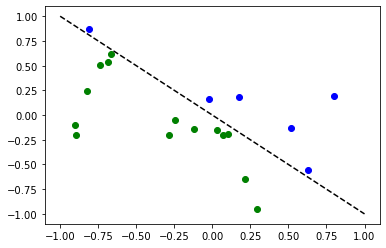

In [40]:
num_inputs = 2  # Feature of inputs (color)
num_samples = 20 # Total number of inputs
X = 2*np.random.rand(num_samples, num_inputs) - 1 #Create a (num_samples, num_inputs) matrix between [-1, 1]
y01 = 1*(np.sum(X, axis=1) >= 0)  # in { 0,  1} # Create a (num_samples, 1) array of 0's and 1's depending on the sum of num_inputs in each row.
y = 2*y01-1                       # in {-1, +1} #Same idea. In this case between -1, +1
y_one_hot = np.zeros((num_samples, 2)) #create a matrix of zeros.

#This part of the code separates blues and green ones by a diagonal y = -x in the depicted range [-1,1] and [-1,1]. . 
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

# Classification with the an OpflowQNN¶
First we show how an OpflowQNN can be used for classification within a NeuralNetworkClassifier. In this context, the OpflowQNN is expected to return one-dimensional output in {-1,1} . This only works for binary classification and we assign the two classes to {-1, 1} . For convenience, we use the TwoLayerQNN, which is a special type of OpflowQNN defined via a feature map and an ansatz.

In [41]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024) # Creating quantum_instance
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance) #TwoLayerQNN algorithm as a function of num_inputs= 2 and quantum_instance
opflow_qnn.forward(X[0, :], np.random.rand(opflow_qnn.num_weights)) #X[0,:] first row with num_weights = 8
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA()) #NeuralNetworkClassifier
opflow_classifier.fit(X, y)

# Results of OpflowQNN¶

In [42]:
opflow_classifier.score(X, y)

0.75

# Plotting the mistakes
In the following lines we highlight the errors with red circles.

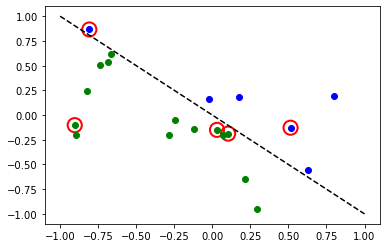

In [43]:
y_predict = opflow_classifier.predict(X) 
for x, y_target, y_p in zip(X, y, y_predict): 
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p: #This part of the code plots big red circles in the cases in which the algorithm failed.
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

# Classification with a CircuitQNN¶
Next we show how a CircuitQNN can be used for classification within a NeuralNetworkClassifier. In this context, the CircuitQNN is expected to return -dimensional probability vector as output, where  denotes the number of classes. Sampling from a QuantumCircuit automatically results in a probability distribution and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

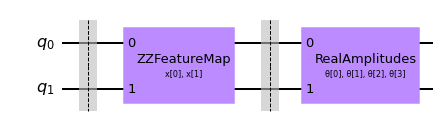

In [44]:
# Construct feature map that transforms features of a given dimension into another. 
feature_map = ZZFeatureMap(num_inputs)
# Construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

#construct the Quantum Circuit
qc = QuantumCircuit(num_inputs) # This creates a 2-qubit initializated to 0. State |00>
qc.barrier()
qc.append(feature_map, range(num_inputs)) # This transforms |00> to a diferent state obeying ZZfeatureMap.
qc.barrier()
qc.append(ansatz, range(num_inputs)) #RealAmplitudes Orcale
qc.decompose().draw(output='mpl')

In [45]:
def parity(x):
    return '{:b}'.format(x).count('1') % 2
output_shape = 2

In [46]:
# Construct QNN
circuit_qnn = CircuitQNN(circuit=qc, #We append the previous quantumcircuit
                         input_params=feature_map.parameters, #This comes from ZZFeatureMap(2).
                         weight_params=ansatz.parameters, #This comes from RealAmplitudes(2).
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)  #From Backend

circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn, optimizer=COBYLA())
circuit_classifier.fit(X, y01)

# Results of CircuitQNN¶

In [47]:
circuit_classifier.score(X, y01)

0.8

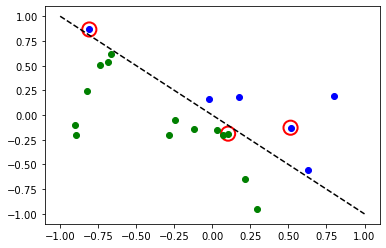

In [48]:
y_predict = circuit_classifier.predict(X)
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

# Variational Quantum Classifier (VQC)
The VQC is a special variant of the NeuralNetworkClassifier with a CircuitQNN. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the CrossEntropyLoss function that expects labels given in one-hot encoded format and will return predictions in that format too

In [49]:
vqc = VQC(feature_map=feature_map,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=COBYLA(),
          quantum_instance=quantum_instance)

In [50]:
# fit classifier to data
vqc.fit(X, y_one_hot)

In [51]:
# score classifier
vqc.score(X, y_one_hot)

0.7

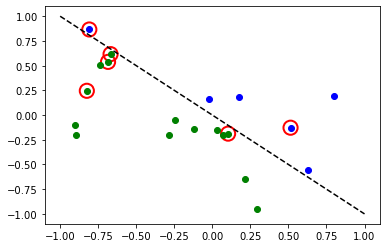

In [52]:
y_predict = vqc.predict(X)
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[1] == 1: #Blues and ones have been inverted!
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

# Conclussions
We have studied different kinds of Neural Networks algorithms to classify data. These are OpflowQNN,CircuitQNN, and VQC. After running them, we have identified the errors by red circles. I feel that something similar could be done with different initial data, namely, with the creditcard.csv. However, I do not have time to explore into it any further.